In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# This file contains all the main external libs we'll use
from fastai.imports import *

C:\tools\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

# Start with some initial parameters

In [5]:
PATH = "data/orchidshummingbirds/"
sz=224

TODO: Try switching this sizing between 224 and 299 and see difference in outcome

In [6]:
os.listdir(PATH)

['models', 'train', 'valid']

In [7]:
os.listdir(f'{PATH}valid')

['hummingbirds', 'orchids']

In [8]:
files = os.listdir(f'{PATH}valid/hummingbirds')[:5]
files

['hummingbird.100.jpg',
 'hummingbird.101.jpg',
 'hummingbird.102.jpg',
 'hummingbird.103.jpg',
 'hummingbird.104.jpg']

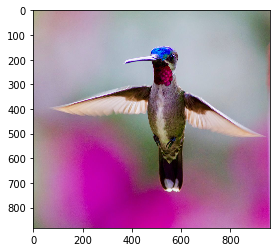

In [9]:
img = plt.imread(f'{PATH}valid/hummingbirds/{files[0]}')
plt.imshow(img);

In [10]:
img.shape

(882, 960, 3)

In [11]:
img[:4,:4]

array([[[172, 179, 135],
        [168, 175, 133],
        [166, 173, 131],
        [167, 174, 132]],

       [[170, 177, 133],
        [167, 174, 132],
        [167, 174, 132],
        [169, 176, 134]],

       [[169, 176, 132],
        [167, 174, 132],
        [167, 174, 132],
        [170, 177, 135]],

       [[169, 176, 132],
        [167, 174, 132],
        [167, 174, 132],
        [170, 177, 135]]], dtype=uint8)

First settings, reusing from lesson1

In [12]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [13]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.90s/it]


epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.57443    0.640188   0.657895  
    1      0.48032    0.296779   0.921053                                                                              



[array([0.29678]), 0.9210526347160339]

In [14]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [15]:
# from here we know that 'hummingbirds' is label 0 and 'orchids' is label 1.
data.classes

['hummingbirds', 'orchids']

In [16]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(38, 2)

In [17]:
log_preds[:10]

array([[-0.24658, -1.52081],
       [-0.55911, -0.84797],
       [-0.85198, -0.55612],
       [-0.2217 , -1.61524],
       [-0.226  , -1.59808],
       [-0.13823, -2.04713],
       [-0.18164, -1.79518],
       [-0.14716, -1.98892],
       [-0.2656 , -1.45564],
       [-0.69498, -0.69131]], dtype=float32)

In [18]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [19]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [20]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [21]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


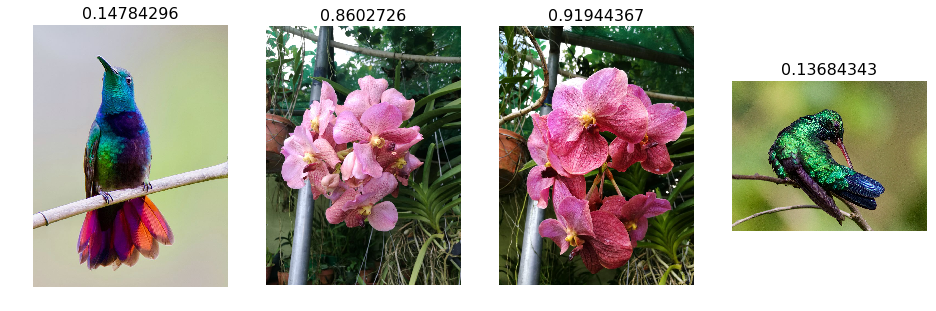

In [22]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [24]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

ValueError: Cannot take a larger sample than population when 'replace=False'

In [25]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct hummingbirds


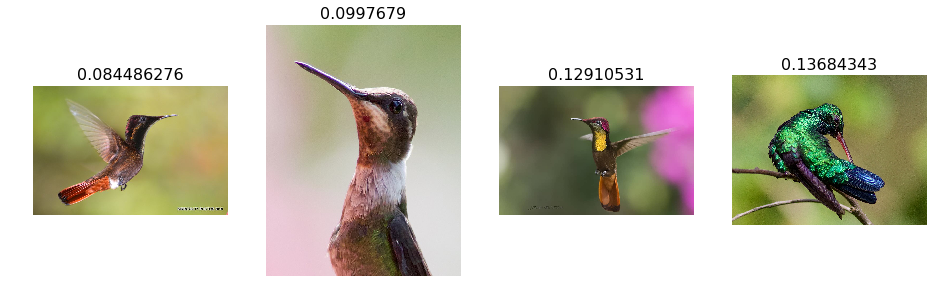

In [26]:
plot_val_with_title(most_by_correct(0, True), "Most correct hummingbirds")

Most correct orchids


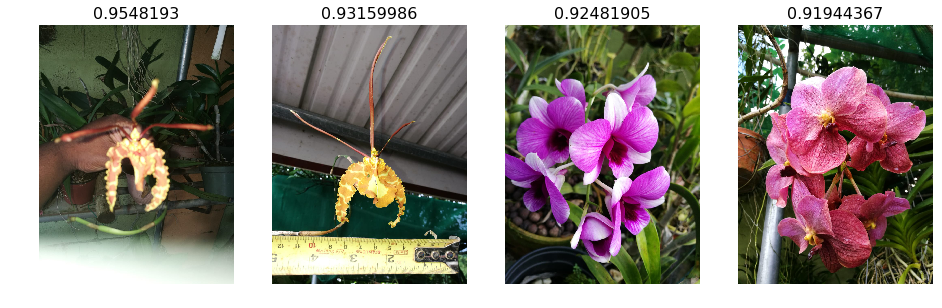

In [27]:
plot_val_with_title(most_by_correct(1, True), "Most correct orchids")

Most incorrect hummingbirds


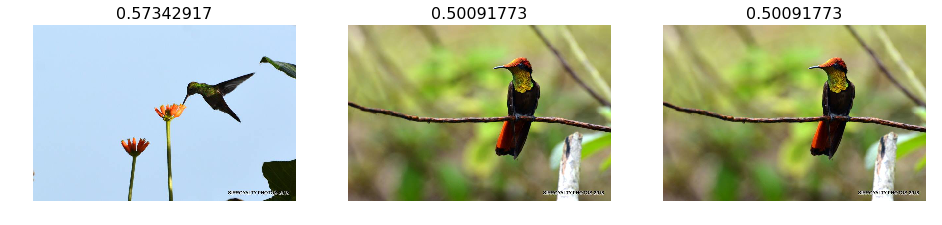

In [28]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect hummingbirds")

In [29]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect orchids")

Most incorrect orchids


<Figure size 1152x576 with 0 Axes>

# Find a suitable learning rate

In [30]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [31]:
lrf=learn.lr_find()

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.713632   0.10007    0.947368  



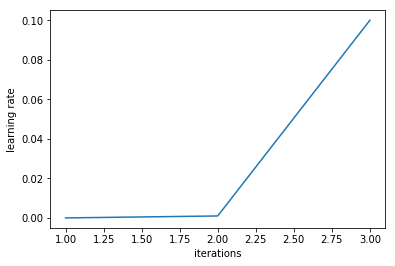

In [32]:
learn.sched.plot_lr()

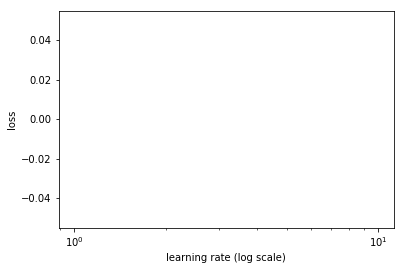

In [33]:
learn.sched.plot()

# Data Augmentation

In [34]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [35]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [36]:
ims = np.stack([get_augs() for i in range(6)])

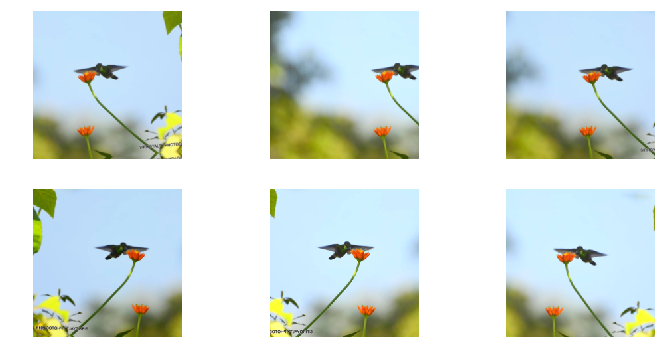

In [37]:
plots(ims, rows=2)

In [38]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [39]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.711458   0.582253   0.684211  



[array([0.58225]), 0.6842105388641357]

In [40]:
learn.precompute=False

In [41]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.569155   0.418712   0.789474  
    1      0.456084   0.27503    0.868421                                                                              
    2      0.376641   0.149603   0.973684                                                                              



[array([0.1496]), 0.9736841917037964]

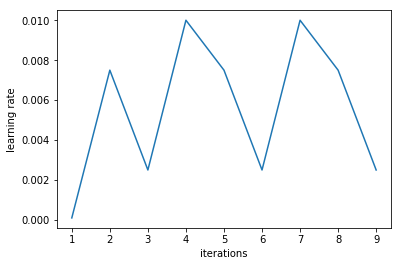

In [42]:
learn.sched.plot_lr()

In [43]:
learn.save('224_lastlayer_oh')

In [44]:
learn.load('224_lastlayer_oh')

In [45]:
learn.unfreeze()

In [46]:
lr=np.array([1e-4,1e-3,1e-2])

In [47]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (2) : out of memory at c:\anaconda2\conda-bld\pytorch_1519501749874\work\torch\lib\thc\generic/THCStorage.cu:58

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.save('224_all_oh')

In [ ]:
learn.load('224_all_oh')

In [ ]:
accuracy_np(probs, y)

Confusion matrix

In [ ]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect hummingbirds")

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect orchids")